In [4]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import scipy.stats as stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold


import os
from matplotlib import font_manager as fm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

## Modeling citation count with Linear Regression

In [10]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 


In [11]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

Read in and clean data.

In [12]:
df = pd.read_csv("features.csv")

df = df[~df.Citations.str.contains('Data')]
df.Accesses = df.Accesses.str.replace('k','000',regex=True)

df.Citations = df.Citations.astype('int64')
df.Accesses = df.Accesses.astype('int64')
df = df.drop(['Document_No'],1)

Add dummies for Dominant_Topic_small.

In [13]:
dummies = pd.get_dummies(df.Dominant_Topic_small)
df = pd.concat([df,dummies],1)

Dropping columns with negative coeffients in stats models w/scaled X_train.

In [14]:
y = df.Citations
X = df.drop(['Citations','Dominant_Topic_large','Accesses','lenTitle','pubYear','pubMonth','Topic_Perc_Contrib_large','norm_contrib_large','delta_Months_large','Topic_Perc_Contrib_small','avg_TPC_small','Counts_small','norm_contrib_small','NatureAC','avg_TPC_large',0.0,1.0,3.0],1)

selected_columns = X.columns.tolist()

Train/test split and feature scaling.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [16]:
std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train)
X_te = std.transform(X_test)

Linear regression model.

In [17]:
model = sm.OLS(y_train, X_tr)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Citations   R-squared (uncentered):                   0.331
Model:                            OLS   Adj. R-squared (uncentered):              0.326
Method:                 Least Squares   F-statistic:                              77.27
Date:                Thu, 16 Jul 2020   Prob (F-statistic):                   3.31e-116
Time:                        21:16:08   Log-Likelihood:                         -6945.1
No. Observations:                1416   AIC:                                  1.391e+04
Df Residuals:                    1407   BIC:                                  1.396e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.1795      0.887      4.711      0.000       2.439       5.920
x2            21.5633      0.889     24.258      0.000      19.820      23.307
x3             0.8719      0.923      0.945      0.345      -0.938       2.682
x4             1.0759      0.878      1.225      0.221      -0.647       2.799
x5             1.2192      1.238      0.984      0.325      -1.210       3.649
x6             2.9933      1.077      2.780      0.006       0.881       5.105
x7             1.3586      0.877      1.549      0.121      -0.361       3.079
x8             0.4285      0.915      0.468      0.640      -1.367       2.224
x9             1.7938      1.380      1.300      0.194      -0.914       4.501
==============================================================================
Omnibus:                     1768.419   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           391961.328
Skew:                           6.353   Prob(JB):                         0.00
Kurtosis:                      83.511   Cond. No.                         2.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
lr = LinearRegression()
fit = lr.fit(X,y)

Residual plot.

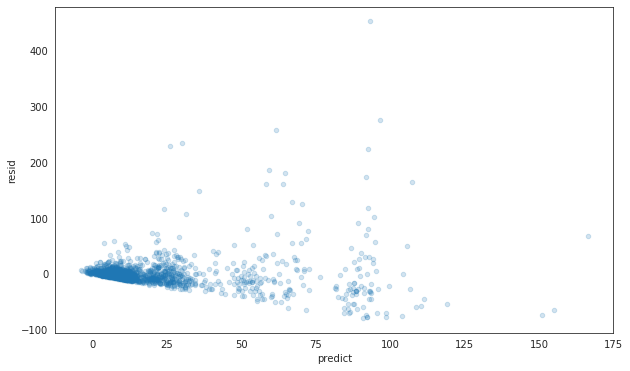

In [19]:
df['predict']=fit.predict(X)
df['resid']=df.Citations-df.predict
with sns.axes_style('white'):
    plot=df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

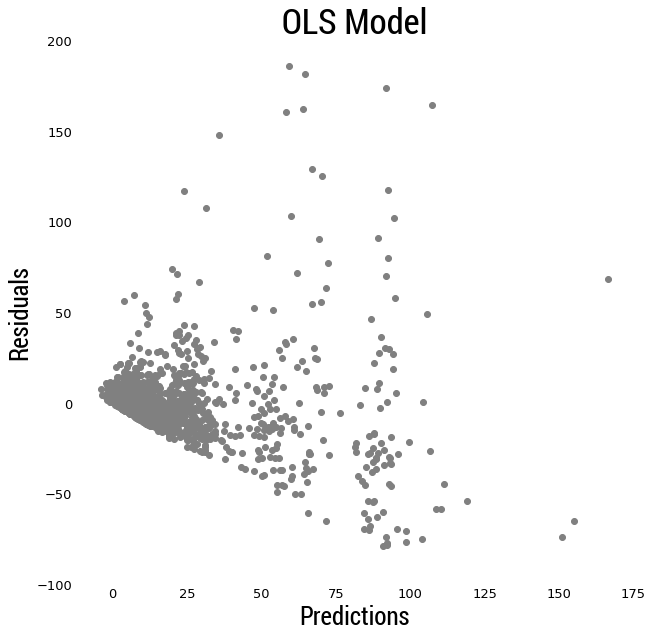

In [44]:
prop = fm.FontProperties(fname = '/Users/kaitlinchaung/Desktop/roboto/RobotoCondensed-Regular.ttf', size=20)

plt.figure(figsize=[10,10])

df['predict']=fit.predict(X)
df['resid']=df.Citations-df.predict
plt.ylim(-100,200)
plt.tick_params(axis=u'both', which=u'both',length=0,labelsize=13)
plt.scatter(df.predict,df.resid,color='grey')
plt.xlabel("Predictions",fontsize=15,fontproperties=prop, size=25)
plt.ylabel("Residuals",fontsize=15,fontproperties=prop, size=25)
plt.title("OLS Model",fontproperties=prop, size=35)
plt.box(on=None)
plt.savefig("ols_resid.png",transparent=True)

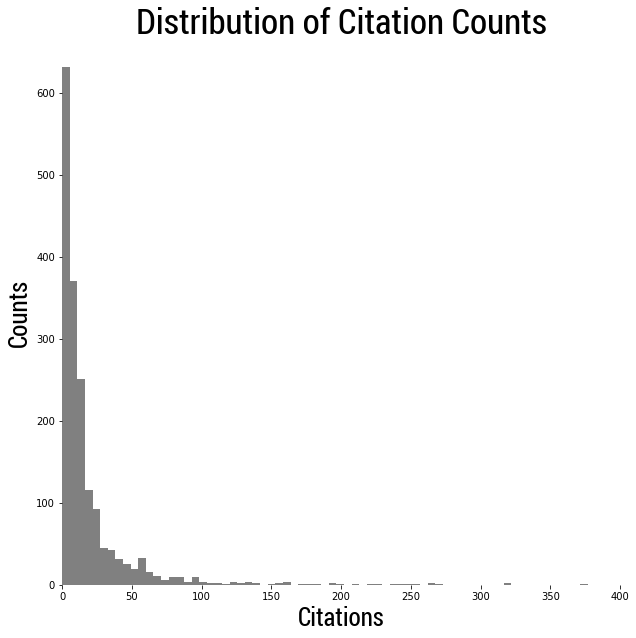

In [58]:
prop = fm.FontProperties(fname = '/Users/kaitlinchaung/Desktop/roboto/RobotoCondensed-Regular.ttf', size=20)

plt.figure(figsize=[10,10])

df.Citations.hist(bins=100, color='grey')
plt.box(on=None)
plt.grid(False)
plt.xlabel("Citations",fontsize=15,fontproperties=prop, size=25)
plt.ylabel("Counts",fontsize=15,fontproperties=prop, size=25)
plt.xlim(0,400)

plt.title("Distribution of Citation Counts",fontproperties=prop, size=35)
plt.savefig('y_hist.png',transparent=True)

QQ plot.

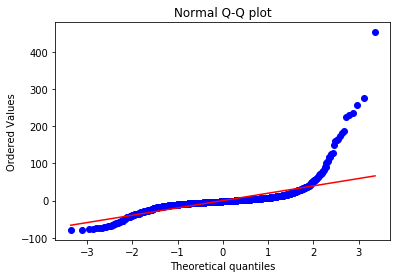

In [300]:
stats.probplot(df['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

Cross validation and Ridge regularization.

In [301]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=8) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X_train), np.array(y_train)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models


for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.4808611751637748, 0.3864147801177831, 0.46274323025821473, 0.28284134661691884, 0.3132318948238514]
Ridge scores:  [0.4808906781890512, 0.38660477509103897, 0.4625351261764765, 0.2835518114828498, 0.3131831268878361] 

Simple mean cv r^2: 0.385 +- 0.079
Ridge mean cv r^2: 0.385 +- 0.078


Optimizing alpha value for Lasso regularization.

In [326]:
X_tr = std.transform(X_train)

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

Use optimal alpha to re-fit model.

In [327]:
best_alpha = lasso_model.alpha_

lasso_model = Lasso(alpha = best_alpha)
lasso_model.fit(X_tr, y_train)

Lasso(alpha=0.22219468609395238, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Lasso Coef before reverse scale.

In [328]:
(list(zip(selected_columns, lasso_model.coef_)))

[('NumAuthors', 4.13258564531714),
 ('ImpactFactor', 20.933211791330017),
 ('Counts_large', 1.2385049617680073),
 ('delta_AvgTPC_large', 0.7844945483757811),
 ('Dominant_Topic_small', 0.633524240655765),
 ('delta_Months_small', 2.2966651098400557),
 ('delta_AvgTPC_small', 0.798848762086418),
 (2.0, 0.2701763014259799),
 (4.0, 1.2859686142698383)]

Reverse scale beta coeffients in Lasso model.

In [329]:
reverse_scaled_beta = std.inverse_transform(lasso_model.coef_)

In [ ]:
Lasso Coef after reverse scale. Remove features with neg coeff.

In [330]:
list(zip(selected_columns, lasso_model.coef_))

[('NumAuthors', 4.13258564531714),
 ('ImpactFactor', 20.933211791330017),
 ('Counts_large', 1.2385049617680073),
 ('delta_AvgTPC_large', 0.7844945483757811),
 ('Dominant_Topic_small', 0.633524240655765),
 ('delta_Months_small', 2.2966651098400557),
 ('delta_AvgTPC_small', 0.798848762086418),
 (2.0, 0.2701763014259799),
 (4.0, 1.2859686142698383)]

Standard scale X_test and use lasso to predict y_test.

In [331]:
X_te = std.transform(X_test)
test_set_pred = lasso_model.predict(X_te)

In [237]:
"""
MAE of prediction
"""

test_mae = mae(y_test, test_set_pred)

print('\nTest MAE: ', test_mae)


Test MAE:  12.072499849240435


In [238]:
"""
R2 of prediction
"""

r2 = r2_score(y_test, test_set_pred)

print('\nTest R2: ', r2)


Test R2:  0.3545128828340288


In [239]:
"""
RMSE of prediction
"""

rmse = sqrt(mean_squared_error(y_test, test_set_pred))

print('\nTest RMSE: ', rmse)


Test RMSE:  27.442894090488878
